In [393]:
import numpy as np
import pandas as pd
import json
import spacy
import matplotlib.pyplot as plt
import datetime
import steamreviews

import bbcode
import string
import logging
import langdetect #https://pypi.org/project/langdetect/
from spacy_langdetect import LanguageDetector
from autocorrect import spell
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
import wordcloud

import gensim

%matplotlib inline

In [394]:
#read in a json file
with open('./data/review_779340.json') as jsonfile:
    jayson = json.load(jsonfile)

In [395]:
review_data = [v for v in jayson['reviews'].values()]
author_key_list = list(review_data[0]['author'].keys())

In [396]:
len(review_data)

8235

In [397]:
review_data[0]

{'recommendationid': '53962547',
 'author': {'steamid': '76561198208274176',
  'num_games_owned': 133,
  'num_reviews': 3,
  'playtime_forever': 4108,
  'playtime_last_two_weeks': 293,
  'last_played': 1562591786},
 'language': 'english',
 'review': "It's finally here.",
 'timestamp_created': 1562591773,
 'timestamp_updated': 1562591773,
 'voted_up': True,
 'votes_up': 0,
 'votes_funny': 0,
 'weighted_vote_score': 0,
 'comment_count': 0,
 'steam_purchase': True,
 'received_for_free': False,
 'written_during_early_access': False}

In [398]:
#for definition of each field in the JSON files, visit (here)[https://partner.steamgames.com/doc/store/getreviews]

steam_dict = {'recommendationid':[review_data[i]['recommendationid'] for i in range(len(review_data))],
              
              'author_steamid':[review_data[i]['author']['steamid'] for i in range(len(review_data))],
              
              'author_num_games_owned':[review_data[i]['author']['num_games_owned'] for i in range(len(review_data))],
              
              'author_num_reviews':[review_data[i]['author']['num_reviews'] for i in range(len(review_data))],
              
              'author_playtime_forever':[review_data[i]['author']['playtime_forever'] for i in range(len(review_data))], 
              #data recorded in minutes - independently verified: https://steamcommunity.com/id/mydogsnameissnowballball/recommended/730/ - 43586 divided by 724.6h on record = 60 min
              
              'author_playtime_last_two_weeks':[review_data[i]['author']['playtime_last_two_weeks'] for i in range(len(review_data))],
              
              'author_last_played':[review_data[i]['author']['last_played'] for i in range(len(review_data))],
              
              'review':[review_data[i]['review'] for i in range(len(review_data))],
              
              'timestamp_created':[review_data[i]['timestamp_created'] for i in range(len(review_data))],
              
              'timestamp_updated':[review_data[i]['timestamp_updated'] for i in range(len(review_data))],
              
              'voted_up':[review_data[i]['voted_up'] for i in range(len(review_data))],
              
              'weighted_vote_score':[review_data[i]['weighted_vote_score'] for i in range(len(review_data))],
              
              'steam_purchase':[review_data[i]['steam_purchase'] for i in range(len(review_data))],
              
              'received_for_free':[review_data[i]['received_for_free'] for i in range(len(review_data))],
              
              'written_during_early_access':[review_data[i]['written_during_early_access'] for i in range(len(review_data))]}

In [399]:
df_raw = pd.DataFrame(steam_dict)
df_raw.head()

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,53962547,76561198208274176,133,3,4108,293,1562591786,It's finally here.,1562591773,1562591773,True,0,True,False,False
1,53962105,76561198169291439,35,5,9078,1901,1562591587,Well for me game still tons of work. i like it...,1562590376,1562590376,False,0,False,False,False
2,53959390,76561197994636073,794,13,898,898,1562577496,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,1562581870,1562581870,True,0,True,False,False
3,53959215,76561198165224929,85,2,2762,321,1562585325,"Good, it's nice",1562581291,1562581291,True,0,True,False,False
4,53958358,76561198005463784,136,1,13120,2389,1562544519,Absolutely great game. \nAll the new diplomacy...,1562578221,1562578221,True,0,True,False,False


In [400]:
len(df_raw['recommendationid'].unique())

8235

In [401]:
df_raw.dtypes

recommendationid                  object
author_steamid                    object
author_num_games_owned             int64
author_num_reviews                 int64
author_playtime_forever            int64
author_playtime_last_two_weeks     int64
author_last_played                 int64
review                            object
timestamp_created                  int64
timestamp_updated                  int64
voted_up                            bool
weighted_vote_score               object
steam_purchase                      bool
received_for_free                   bool
written_during_early_access         bool
dtype: object

In [402]:
df_raw.head()

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,53962547,76561198208274176,133,3,4108,293,1562591786,It's finally here.,1562591773,1562591773,True,0,True,False,False
1,53962105,76561198169291439,35,5,9078,1901,1562591587,Well for me game still tons of work. i like it...,1562590376,1562590376,False,0,False,False,False
2,53959390,76561197994636073,794,13,898,898,1562577496,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,1562581870,1562581870,True,0,True,False,False
3,53959215,76561198165224929,85,2,2762,321,1562585325,"Good, it's nice",1562581291,1562581291,True,0,True,False,False
4,53958358,76561198005463784,136,1,13120,2389,1562544519,Absolutely great game. \nAll the new diplomacy...,1562578221,1562578221,True,0,True,False,False


In [403]:
df_raw.tail()

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
8230,50776360,76561198139831915,13,1,2047,171,1561968832,game simply dose not load on 1st hour release ...,1558596424,1558596424,False,0.221157893538475037,False,False,False
8231,50776299,76561198051524426,137,2,6702,1191,1562587614,i haven't even play it but i just to give cred...,1558596164,1558596164,True,0.355761975049972534,True,False,False
8232,50776268,76561197998239707,190,11,2351,39,1562026953,beautiful a Great addition to the franchise,1558595971,1558595971,True,0.459968507289886475,True,False,False
8233,50776247,76561198048592111,138,13,9099,641,1562517286,Huahahaha....hahahaha....,1558595851,1558595851,True,0.320511430501937866,False,False,False
8234,50776089,76561197979911851,18545,73,1298,0,1558687395,[h1]Total War: THREE KINGDOMS[/h1]\n\nTotal Wa...,1558594622,1558598676,True,0.80980914831161499,False,False,False


In [404]:
df_raw = df_raw[df_raw['received_for_free']==False] # Redundant for F2P games, because nobody can buy them

In [405]:
df_raw['voted_up'].value_counts(normalize=True)

True     0.898773
False    0.101227
Name: voted_up, dtype: float64

In [406]:
df_raw['recommendationid'] = df_raw['recommendationid'].map(lambda x: str(x))
df_raw['author_steamid'] = df_raw['author_steamid'].map(lambda x: str(x))
df_raw['author_last_played'] = df_raw['author_last_played'].map(lambda x: str(x))
df_raw['timestamp_created'] = df_raw['timestamp_created'].map(lambda x: str(x))
df_raw['timestamp_updated'] = df_raw['timestamp_updated'].map(lambda x: str(x))
df_raw['weighted_vote_score'] = df_raw['weighted_vote_score'].map(lambda x: float(x))

In [407]:
df_raw['weighted_vote_score'].dtype

dtype('float64')

(array([5846.,   10.,   32.,  126.,  651., 1388.,   49.,   22.,   16.,
          10.]),
 array([0.        , 0.09546572, 0.19093144, 0.28639716, 0.38186288,
        0.4773286 , 0.57279432, 0.66826004, 0.76372576, 0.85919148,
        0.9546572 ]),
 <a list of 10 Patch objects>)

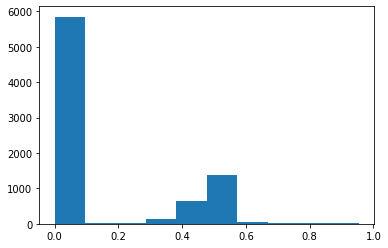

In [408]:
plt.hist(df_raw['weighted_vote_score'])

In [409]:
df_raw['received_for_free'].value_counts(normalize=True) #Redundant for F2P games

False    1.0
Name: received_for_free, dtype: float64

In [410]:
df_raw['steam_purchase'].value_counts(normalize=True) #Semi-redundant for F2P games; some can be gotten by activating Steam Keys

True     0.725399
False    0.274601
Name: steam_purchase, dtype: float64

In [411]:
datetime.datetime.utcfromtimestamp(min(df_raw['timestamp_created'].astype(int))).strftime('%Y-%m-%d %H:%M:%S')

'2019-05-23 06:57:02'

In [412]:
len(df_raw['recommendationid'].unique())

8150

In [413]:
df_raw['author_playtime_forever']=df_raw['author_playtime_forever']/60
df_raw['author_playtime_last_two_weeks']=df_raw['author_playtime_last_two_weeks']/60

In [414]:
df_raw_num = df_raw.select_dtypes(exclude=['O','bool'])

In [415]:
df_raw_num_high_play = df_raw_num[(df_raw_num['author_playtime_forever']>2) & (df_raw_num['author_playtime_last_two_weeks']>=0.5)]

In [416]:
len(df_raw_num_high_play)

4788

In [417]:
df_raw_num_high_play.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,weighted_vote_score
count,4788.000000,4788.000000,4788.000000,4788.000000,4788.000000
mean,184.085004,7.459900,94.536832,20.867662,0.106508
std,296.819710,13.535872,77.014302,23.981357,0.208447
min,1.000000,1.000000,2.116667,0.500000,0.000000
25%,60.000000,1.000000,43.300000,4.500000,0.000000
50%,120.000000,3.000000,74.791667,13.016667,0.000000
75%,231.000000,7.000000,121.787500,28.270833,0.000000
max,11028.000000,277.000000,765.683333,228.900000,0.942770


(array([291., 506., 593., 590., 531., 475., 360., 284., 245., 189., 117.,
        111.,  81.,  65.,  59.,  43.,  47.,  23.,  35.,  28.,  26.,  16.,
         10.,  10.,   9.,   8.,   4.,   7.,   7.,   2.,   1.,   0.,   3.,
          3.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,   2.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.11666667,  17.388     ,  32.65933333,  47.93066667,
         63.202     ,  78.47333333,  93.74466667, 109.016     ,
        124.28733333, 139.55866667, 154.83      , 170.10133333,
        185.37266667, 200.644     , 215.91533333, 231.18666667,
        246.458     , 261.72933333, 277.00066667, 292.272     ,
        307.54333333, 322.81466667, 338.086     , 353.35733333,
        368.62866667, 383.9       , 399.17133333, 414.44266667,
        429.714     , 444.98533333, 460.25666667, 475.528     ,
        490.79933333, 506.07066667, 521.342     , 536.61333333,
        551.88466667, 567.156     , 582.42733333, 597.69866667,
        612.97    

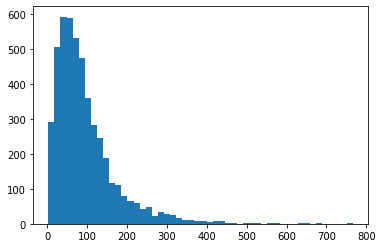

In [418]:
plt.hist(df_raw_num_high_play['author_playtime_forever'],bins=50)

Most players on this game have 2 to 5000 hours on record from the time they began playing, and all reviewers played at least 30 minutes (long enough for 1 match) in the past 2 weeks.

Recent information is more important, and opinions are more valid when players have recently played the game.

In [419]:
df_usable = df_raw[(df_raw['author_playtime_forever']>=3)& (df_raw_num['author_playtime_last_two_weeks']>=(10/60))] #recent opinions are more important, and user must have played longer than refundable playtime cutoff
df_usable.head(2)

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,53962547,76561198208274176,133,3,68.466667,4.883333,1562591786,It's finally here.,1562591773,1562591773,True,0.0,True,False,False
1,53962105,76561198169291439,35,5,151.300000,31.683333,1562591587,Well for me game still tons of work. i like it...,1562590376,1562590376,False,0.0,False,False,False


In [420]:
df_usable.iloc[0,7]

"It's finally here."

In [421]:
df_usable['review'].describe()

count           5045
unique          4720
top       Great game
freq              33
Name: review, dtype: object

In [422]:
review_lengths = [len(x.split()) for x in df_usable['review']]
print(len(review_lengths)) #no of reviews
print(sum(review_lengths)/len(review_lengths)) #mean character length of a review
df_usable['review_length']=df_usable['review'].map(lambda x: len(x.split()))

5045
53.165906838453914


C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(array([4.108e+03, 4.920e+02, 1.860e+02, 8.000e+01, 5.500e+01, 2.900e+01,
        2.500e+01, 2.100e+01, 1.000e+01, 8.000e+00, 7.000e+00, 8.000e+00,
        6.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00]),
 array([1.0000e+00, 7.3500e+01, 1.4600e+02, 2.1850e+02, 2.9100e+02,
        3.6350e+02, 4.3600e+02, 5.0850e+02, 5.8100e+02, 6.5350e+02,
        7.2600e+02, 7.9850e+02, 8.7100e+02, 9.4350e+02, 1.0160e+03,
        1.0885e+03, 1.1610e+03, 1.2335e+03, 1.3060e+03, 1.3785e+03,
        1.4510e+03]),
 <a list of 20 Patch objects>)

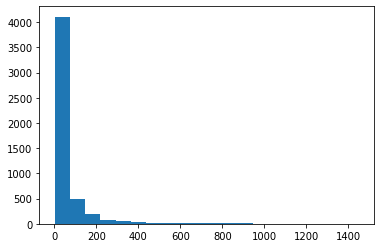

In [423]:
plt.hist(df_usable['review_length'],bins=20)

In [424]:
df_usable.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,weighted_vote_score,review_length
count,5045.00000,5045.000000,5045.000000,5045.000000,5045.000000,5045.000000
mean,185.48444,7.589296,92.507380,19.816056,0.109900,53.165907
std,292.44326,13.602280,75.977872,23.799187,0.210549,112.521953
min,1.00000,1.000000,3.066667,0.166667,0.000000,1.000000
25%,60.00000,1.000000,41.933333,3.533333,0.000000,5.000000
50%,121.00000,3.000000,72.933333,11.883333,0.000000,16.000000
75%,234.00000,8.000000,119.250000,27.283333,0.000000,50.000000
max,11028.00000,277.000000,765.683333,228.900000,0.942770,1451.000000


In [425]:
np.percentile(df_usable['review_length'],25)

5.0

In [426]:
df_ready = df_usable[df_usable['review_length']>np.percentile(df_usable['review_length'],25)].reset_index(drop=True) #Remove very short reviews that are likely to be junk

In [427]:
print(min(df_ready['review_length'])) #shortest review length, in words. space-delimited
df_ready.head()

6


,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length
0,53962105,76561198169291439,35,5,151.300000,31.683333,1562591587,Well for me game still tons of work. i like it...,1562590376,1562590376,False,0.000000,False,False,False,413
1,53959390,76561197994636073,794,13,14.966667,14.966667,1562577496,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,1562581870,1562581870,True,0.000000,True,False,False,9
2,53958358,76561198005463784,136,1,218.666667,39.816667,1562544519,Absolutely great game. \nAll the new diplomacy...,1562578221,1562578221,True,0.000000,True,False,False,56
3,53957576,76561198130236006,131,54,88.283333,70.750000,1562587903,A fine blend of Warhammer I/II: Total War and ...,1562575368,1562575368,True,0.540636,True,False,False,84
4,53955710,76561198030974342,34,15,5.800000,4.500000,1562533937,Innovative Total Game that has lots of persona...,1562568222,1562568222,True,0.000000,True,False,False,67


In [428]:
len(df_ready)

3727

(array([2.847e+03, 4.530e+02, 1.730e+02, 7.700e+01, 5.400e+01, 3.000e+01,
        2.500e+01, 2.000e+01, 1.100e+01, 6.000e+00, 7.000e+00, 9.000e+00,
        5.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00]),
 array([   6.  ,   78.25,  150.5 ,  222.75,  295.  ,  367.25,  439.5 ,
         511.75,  584.  ,  656.25,  728.5 ,  800.75,  873.  ,  945.25,
        1017.5 , 1089.75, 1162.  , 1234.25, 1306.5 , 1378.75, 1451.  ]),
 <a list of 20 Patch objects>)

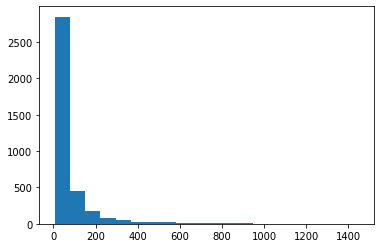

In [429]:
plt.hist(df_ready['review_length'],bins=20)

In [430]:
df_ready.iloc[0,7] #Most reviews are between 4 and 200 words long.

'Well for me game still tons of work. i like it but just cant recommend.\n1. Diplomacy . It is joke. Nothing works. You have trade and military access with CAO CAO ? War declaration next turn. You are too small ? well you will get war declaration each turn . In this game its ok if you are at war with more factions than you have armies.  Oh and if you are too big ? guess what ? still war each turn. i mean did they even test this diplomacy ? 3 war declaration in t run ? for nothing ?i am total war  veteran and i can see what they have done with AI. Rather than improve it and make it play by the rules like paradox have done. They rather make AI cheat and brake rules like having ,,shadow income".  Or have some sort of punishment for breaking pacts. Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.\n2. Troops. In TWH( also in Rome) all is simple. You have about 3 chains of troop buildings that supply you with certain ki

In [431]:
df_ready['review'].describe()

count                              3727
unique                             3718
top       Best Total War since Shogun 2
freq                                  4
Name: review, dtype: object

In [432]:
df_ready['review'].value_counts()[:10] #Get top 10 most repeated reviews in case of review bombs/spamming, which players are known to do.

Best Total War since Shogun 2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Review Spam/Ham Problem
- Some reviews have been spammed multiple times a day. 
- All reviewers' opinions are important, but repeated reviews ultimate only belong to one player. 
- Removing duplicates controls the "vocal minority" problem effectively.
- Need to clean away any text that is not strictly English. It is possible for text from other languages to be wrongly labelled as English. (Reviews scraped were all labelled as being in English)

In [433]:
#drop duplicate entries in reviews, because they are considered spam
df_cleaning = df_ready.drop_duplicates(subset='review')

In [434]:
df_cleaning.select_dtypes(include='O').describe()

,recommendationid,author_steamid,author_last_played,review,timestamp_created,timestamp_updated
count,3718,3718,3718,3718,3718,3718
unique,3718,3718,3696,3718,3710,3713
top,50951596,76561198165914219,1562592383,For me this is one of the best of Total war se...,1561803652,1558619677
freq,1,1,2,1,2,2


In [435]:
deduplicated_rows = abs(len(df_cleaning) - len(df_ready)) #find out how many rows were removed during deduplication
print(deduplicated_rows)
print(deduplicated_rows/len(df_ready)) #Percentage of data that was duplicated

9
0.0024148108398175474


Things to do:
http://t-redactyl.io/blog/2017/06/text-cleaning-in-multiple-languages.html
- Clean languages
- Lemmatise

# English! Do you speak it?!

In [436]:
#get languages by document
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)
    
def get_lang_doc(text):
    doc = nlp(text)
    return doc._.language['language']

#count languages for sentences in document -- decided not to use this because 1. it slows computation a lot 2. it throws a lot of false positives, especially when splitting short lines
def get_langs_sent(text):
    langs={}
    lang_st={}
    doc = nlp(text)
    
    for i, sent in enumerate(doc.sents):
        langs[i]=sent._.language['language'] #Iterating through sentence level, thus only need to add language. Probability scores should be quite high per sentence.
    
    lang_st = list(set(langs.values())) #Get language code of each language that appeared. As long as more than 1 language appears, the review will be excluded.
    
    return lang_st

In [437]:
dc=df_cleaning['review'][np.random.randint(0,len(df_cleaning['review']))]
doc=nlp(dc)
print(dc+'\n-----')
print(doc._.language)

Very amazing game to play IMO. First time buying total wars and im loving it
-----
{'language': 'en', 'score': 0.8571392152585912}


In [438]:
get_langs_sent(df_cleaning['review'][np.random.randint(0,len(df_cleaning['review']))])

['id', 'en']

In [439]:
#df_cleaning['lang_count'] 
trial_doc_langs = df_cleaning['review'][:5].map(lambda x: get_lang_doc(x))

In [440]:
trial_doc_langs

0    en
1    en
2    en
3    en
4    en
Name: review, dtype: object

In [441]:
doc_langs = [get_lang_doc(x) for x in df_cleaning['review']] #WARNING: SLOW! May take a couple of minutes to finish.

In [442]:
df_cleaning['review_lang']=doc_langs

C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [443]:
df_cleaning.to_csv('./dataframes/df_cleaning.csv') #saving so I don't have to run the cleaning operation again

In [444]:
df_cleaning = pd.read_csv('./dataframes/df_cleaning.csv',index_col=0)

In [445]:
df_langs_cleaned = df_cleaning[df_cleaning['review_lang']=='en'].reset_index(drop=True)
len(df_langs_cleaned)

3659

In [446]:
mult_ln_reviews_dropped = (len(df_cleaning) - len(df_langs_cleaned))/len(df_cleaning)
print(mult_ln_reviews_dropped)

0.015868746637977407


### Dropped multi-lingual reviews

Inclusive of false positives, 18.9% of the usable reviews were dropped because they had more than 1 language detected. This is acceptable loss of data, because multilingual reviews will make models inaccurate and slow down training processes.

### Text cleaning

Steam reviews use BBCode, a form of markup language used to format bulletin board posts (hence the name). Regex can be used, but there is a pre-built package for taking care of BBCode in text, so we are using that instead.

In [447]:
parser=bbcode.Parser()

In [448]:
#open pre-defined dictionary of english contractions, saved separately to avoid clutter (long dictionary, can be loaded as dict using json package)
with open('./en_contractions/contra_dict.txt') as contra_dict:
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [449]:
#popular Total War games' keywords
#tw_kw = ['medieval','medieval_2','shogun','shogun_2','rome','rome_2','empire','napoleon','warhammer','warhammer_ii',
#         'vikings','thrones','britannia','attila','3_kingdoms','three_kingdoms','kingdoms']

def parse_clean(text):
    parsed_text = parser.strip(text) #remove all BBcode notations from text to enable further processing
    
    text = expandContractions(parsed_text) #expand all contractions and return all text in lower case
    
    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet.
    text = [word for word in text.split() if word not in en_stopwords and len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 
   
    #remove punctuation and numbers and roman numerals up to II -- numbered sequels exist, but only the keywords really matter when making comparisons between games
    clean_text = [s.translate(str.maketrans('', '', string.punctuation)) 
                  for s in text]
    
    return clean_text

In [450]:
#creating a test review to make sure parse_clean() works as intended
se="I like Total War: 3 Kingdoms. I enjoyed the campaign. Would be nice if there was more story. Ma Teng is OP. DO NOT PURSUE LU BU. Cao Cao's proxy war ability is awesome."
print(parse_clean(se))
# doc=nlp(se)
# print([(X.text, X.label_) for X in doc.ents]) # Commenting out these two lines. They may be useful later.

['total', 'war', 'kingdoms', 'enjoyed', 'campaign', 'nice', 'story', 'ma', 'teng', 'op', 'pursue', 'lu', 'bu', 'cao', 'caos', 'proxy', 'war', 'ability', 'awesome']


In [451]:
txt = df_cleaning['review'][np.random.randint(0,len(df_cleaning))]
print(txt)
print(parse_clean(txt))

So here is the thing, i'm not one to actively put reviews on games that i'm cracked out on, but this game is a massive culmination of all the great things CA has put together over the years into 1 game, and in an era that i absolutely love. The entire three kingdoms era has always enthralled me since i was young, yes it did start off with the dynasty warriors series, but it has excelled beyond that a long time ago. This game alone has sufficed my love for building the cities, taking control of the areas, RTS combat during round, hero duels watching sun jian or cao cao or lie bei beat the ever living crap out of someone is one of the greatest things to watch. This game feels like its an absolute mix of everything someone that enjoys what CA has made over the years. I love this game, and the fact that CA did it so beautifully is an amazing feat of itself. The best part about this game is you can follow one of the warlords of the era, OR create your own and forge your own destiny among an

In [452]:
df_langs_cleaned['clean_reviews'] = df_langs_cleaned['review'].map(lambda x: parse_clean(x))

In [453]:
df_langs_cleaned.head(2)

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length,review_lang,clean_reviews
0,53962105,76561198169291439,35,5,151.300000,31.683333,1562591587,Well for me game still tons of work. i like it...,1562590376,1562590376,False,0.0,False,False,False,413,en,"[tons, work, recommend, 1, diplomacy, joke, wo..."
1,53959390,76561197994636073,794,13,14.966667,14.966667,1562577496,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,1562581870,1562581870,True,0.0,True,False,False,9,en,"[pursued, lu, bu, lu, bu]"


In [454]:
df_langs_cleaned.to_csv('./dataframes/df_langs_cleaned.csv')

In [455]:
final_df = pd.read_csv('./dataframes/df_langs_cleaned.csv',index_col=0)

In [456]:
final_df = final_df[['review','clean_reviews']]
final_df.head()

,review,clean_reviews
0,Well for me game still tons of work. i like it...,"['tons', 'work', 'recommend', '1', 'diplomacy'..."
1,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"['pursued', 'lu', 'bu', 'lu', 'bu']"
2,Absolutely great game. \nAll the new diplomacy...,"['absolutely', 'great', 'game', 'new', 'diplom..."
3,A fine blend of Warhammer I/II: Total War and ...,"['fine', 'blend', 'warhammer', 'iii', 'total',..."
4,Innovative Total Game that has lots of persona...,"['innovative', 'total', 'lots', 'personality',..."


In [457]:
final_df['clean_reviews'] = final_df['clean_reviews'].map(lambda x: ''.join(c for c in x if c not in string.punctuation).split()) 
#Reading in the DF from a CSV turned the list of words in each cell into string, so we have to remove the punctuation and split them again

In [458]:
final_df.head()

,review,clean_reviews
0,Well for me game still tons of work. i like it...,"[tons, work, recommend, 1, diplomacy, joke, wo..."
1,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"[pursued, lu, bu, lu, bu]"
2,Absolutely great game. \nAll the new diplomacy...,"[absolutely, great, game, new, diplomacy, opti..."
3,A fine blend of Warhammer I/II: Total War and ...,"[fine, blend, warhammer, iii, total, war, shog..."
4,Innovative Total Game that has lots of persona...,"[innovative, total, lots, personality, brings,..."


In [459]:
#get all words in the corpus
word_lst = []
for i in final_df['clean_reviews']:
    word_lst.extend(i)
    
cleaned_words = word_lst

print(len(word_lst))

124610


In [460]:
wordfreq = nltk.FreqDist(word_lst)
# Print the most common words.
print(wordfreq.most_common(100))

[('war', 2936), ('total', 2862), ('game', 1343), ('best', 1145), ('one', 1131), ('games', 1047), ('good', 917), ('great', 864), ('campaign', 799), ('three', 768), ('diplomacy', 754), ('time', 712), ('kingdoms', 685), ('play', 676), ('new', 664), ('battles', 654), ('warhammer', 627), ('series', 625), ('units', 581), ('played', 570), ('fun', 548), ('it', 547), ('tw', 530), ('ai', 516), ('love', 506), ('romance', 504), ('far', 476), ('shogun', 475), ('battle', 457), ('characters', 456), ('mode', 450), ('better', 449), ('generals', 449), ('unit', 413), ('ca', 384), ('playing', 382), ('map', 375), ('feel', 367), ('lot', 363), ('factions', 338), ('historical', 336), ('hours', 324), ('2', 314), ('fan', 312), ('faction', 311), ('army', 308), ('cao', 306), ('dlc', 300), ('china', 299), ('way', 298), ('recommend', 296), ('different', 294), ('bit', 292), ('rome', 291), ('amazing', 291), ('want', 281), ('previous', 281), ('character', 271), ('mechanics', 266), ('strategy', 264), ('think', 260), ('

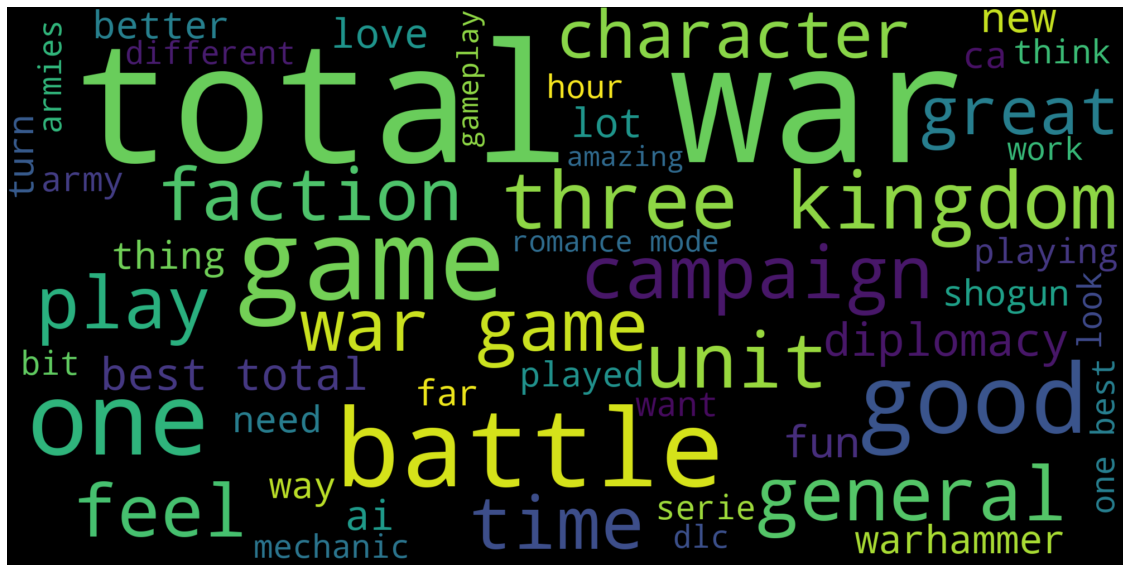

In [461]:
#get a string of text
text = ' '.join(w for w in word_lst)

# Create and generate a word cloud image:
wcd = wordcloud.WordCloud(width = 2000, height=1000, max_words = 50).generate(text)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

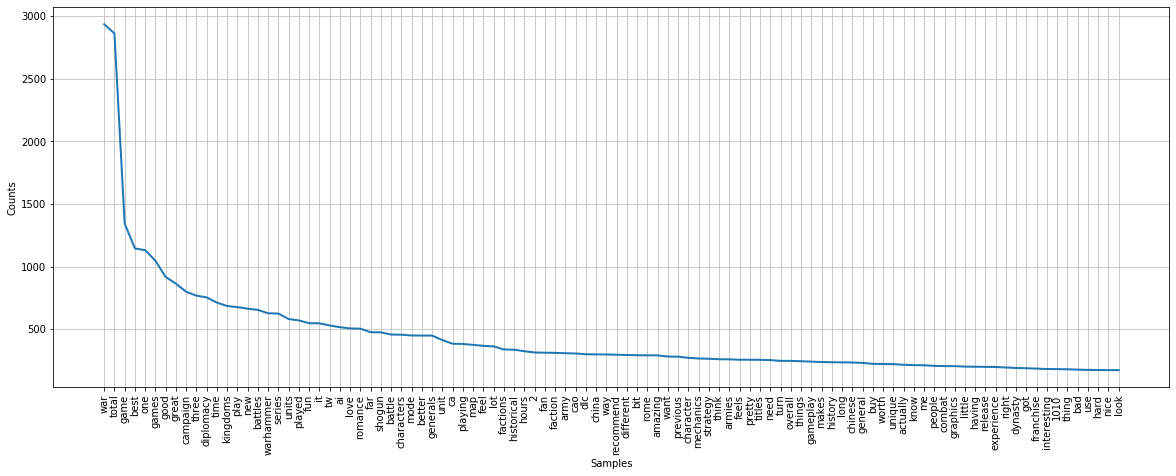

In [462]:
plt.figure(figsize=(20,7))
wordfreq.plot(100,cumulative=False)

In [463]:
# Credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this code

# Build the bigram and trigram models
bigram = gensim.models.Phrases(list(final_df['clean_reviews']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to train generator model]
trigram = gensim.models.Phrases(bigram[list(final_df['clean_reviews'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [464]:
#add more stopwords to be cleaned out of the corpus

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['game','like','I','i']) #add custom stopwords. CA is short for Creative Assembly, the developer. ['best','total','war'] to be considered after LDA run 1
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

def remove_stopwords(doc):
    words = [w for w in doc if w not in en_stopwords]
    return words

#All word lengths should be <= the longest word in the English language. It is not uncommon for people spam incoherent letters on the Internet
new_word_lst = remove_stopwords(word_lst)

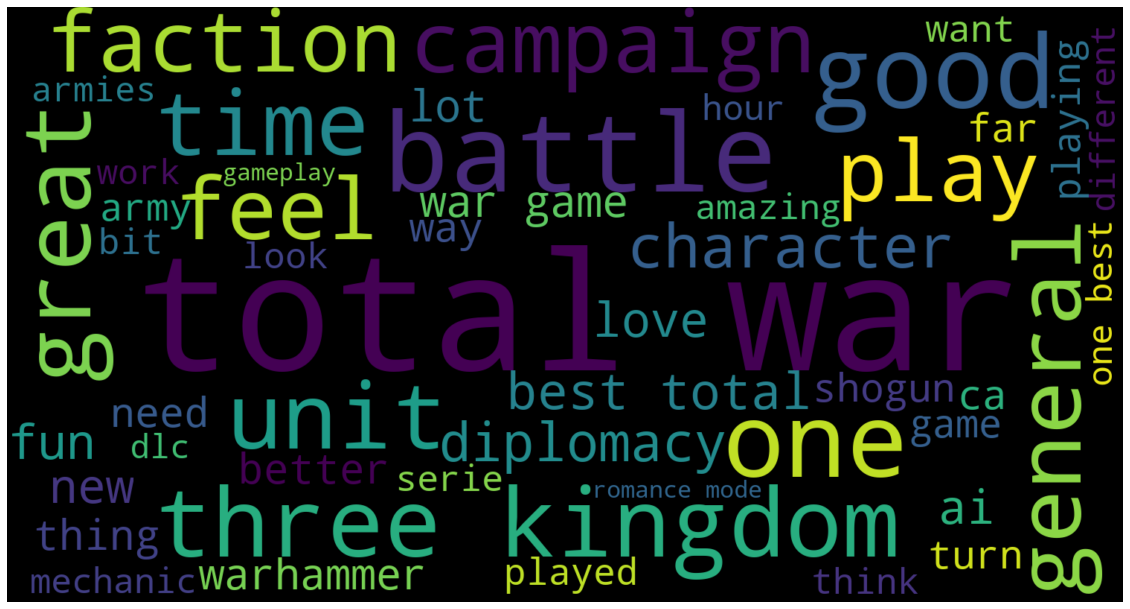

In [465]:
#get a string of text
text2 = ' '.join(w for w in new_word_lst)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text2)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

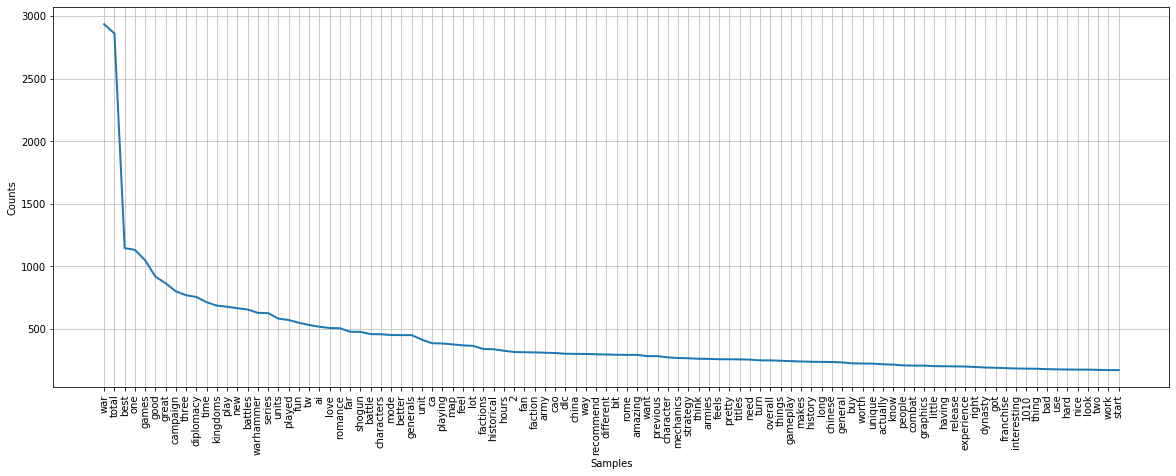

In [466]:
wordfreq2 = nltk.FreqDist(new_word_lst)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq2.plot(100,cumulative=False)

### Word Frequencies

While it can be seen that the stopwords made the word clouds have clearer terms, we will take a step back and make n-grams before we remove stopwords and numbers, and lemmatise text.

This is just in case any of these words form part of an n-gram that may prove crucial to more accurate analysis later.

In [467]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [507]:
lemmatizer=WordNetLemmatizer()

def lemma(clean_text):
    
    clean_text = [w for w in clean_text if w not in ['one','two','three'] and not w.isdigit()] #for final removal digits up to 3 that have been converted to text for n-grams

    #Iterate through all text in document to remove punctuation and lemmatise each word thereafter
    lemma_text = [w if '_' in w    #lemmatiser should ignore all n-grams because it can't reasonably lemmatise them
                  else lemmatizer.lemmatize(w)
                 for w in clean_text ]
    
    return lemma_text

In [508]:
def stop_lemma(text):
    text = remove_stopwords(text)
    text = lemma(text)
    return text

#remove newly-added stopwords from clean reviews after getting bigrams and trigrams then lemmatise, just in case the original words happen to be part of any n-grams.
#any remaining numbers can be removed at this point, as they are unlikely to be part of any helpful terms.

In [509]:
#testing bigram function
t = [['three', 'kingdoms', 'period'],['romance', 'of', 'the', 'three', 'kingdoms'],['three', 'kingdoms', 'strategy'],['romance', 'of', 'three', 'kingdoms'],
     ['three', 'kingdoms', 'period'],['3', 'kingdoms', 'period'],['3', 'kingdoms', 'period'],['3', 'kingdoms', 'period']]
print(make_bigrams(t))

[['three_kingdoms', 'period'], ['romance', 'of', 'the', 'three_kingdoms'], ['three_kingdoms', 'strategy'], ['romance', 'of', 'three_kingdoms'], ['three_kingdoms', 'period'], ['3', 'kingdoms_period'], ['3', 'kingdoms_period'], ['3', 'kingdoms_period']]


In [523]:
num_dict = {'0':'zero',
             '1':'one',
             '2':'two',
             '3':'three',
             #'i':'one',      skipped because 'i' will conflict with the pronoun "i"
             'ii':'two',
             'iii':'three'   
            }

# only going up to number 3 because most games have up to 3 instalments. Many contrary examples exist though, e.g. Final Fantasy XIV and XV; Dynasty Warriors 9; RotK XIII.
#In Total War's case, we only need up to 3 to capture "three kingdoms" in an n-gram.

def num2word(d):
    
    if len(d) == 1 and d in '0123' or d in ['ii','iii']:
        word = num_dict[d]
    
    else:
        word = d
    
    return word

In [511]:
final_df['word_only_reviews'] = final_df['clean_reviews'].map(lambda x: [num2word(y) for y in x])

In [512]:
final_df.head()

,review,clean_reviews,word_only_reviews,2gram_reviews,3gram_reviews
0,Well for me game still tons of work. i like it...,"[tons, work, recommend, 1, diplomacy, joke, wo...","[tons, work, recommend, one, diplomacy, joke, ...","[ton, work, recommend, one, diplomacy, joke, w...","[ton, work, recommend, one, diplomacy, joke, w..."
1,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"[pursued, lu, bu, lu, bu]","[pursued, lu, bu, lu, bu]","[pursued, lu_bu, lu_bu]","[pursued, lu_bu, lu_bu]"
2,Absolutely great game. \nAll the new diplomacy...,"[absolutely, great, game, new, diplomacy, opti...","[absolutely, great, game, new, diplomacy, opti...","[absolutely, great, new, diplomacy_options, de...","[absolutely, great_game, new, diplomacy_option..."
3,A fine blend of Warhammer I/II: Total War and ...,"[fine, blend, warhammer, iii, total, war, shog...","[fine, blend, warhammer, three, total, war, sh...","[fine, blend, warhammer, three, total_war, sho...","[fine, blend, warhammer, three, total_war, sho..."
4,Innovative Total Game that has lots of persona...,"[innovative, total, lots, personality, brings,...","[innovative, total, lots, personality, brings,...","[innovative, total, lot, personality, brings, ...","[innovative, total, lot, personality, brings, ..."


In [513]:
final_df['2gram_reviews'] = make_bigrams(final_df['word_only_reviews'])

In [514]:
final_df['3gram_reviews'] = make_trigrams(final_df['word_only_reviews'])

In [515]:
final_df['2gram_reviews'] = final_df['2gram_reviews'].map(lambda x: stop_lemma(x))
final_df['3gram_reviews'] = final_df['3gram_reviews'].map(lambda x: stop_lemma(x))

In [516]:
final_df.head(2)

,review,clean_reviews,word_only_reviews,2gram_reviews,3gram_reviews
0,Well for me game still tons of work. i like it...,"[tons, work, recommend, 1, diplomacy, joke, wo...","[tons, work, recommend, one, diplomacy, joke, ...","[ton, work, recommend, diplomacy, joke, work, ...","[ton, work, recommend, diplomacy, joke, work, ..."
1,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"[pursued, lu, bu, lu, bu]","[pursued, lu, bu, lu, bu]","[pursued, lu_bu, lu_bu]","[pursued, lu_bu, lu_bu]"


In [517]:
final_df.to_csv('./dataframes/final_df.csv')

In [518]:
word_lst_2gram = []
for i in final_df['2gram_reviews']:
    word_lst_2gram.extend(i)
    
word_lst_3gram = []
for i in final_df['3gram_reviews']:
    word_lst_3gram.extend(i)

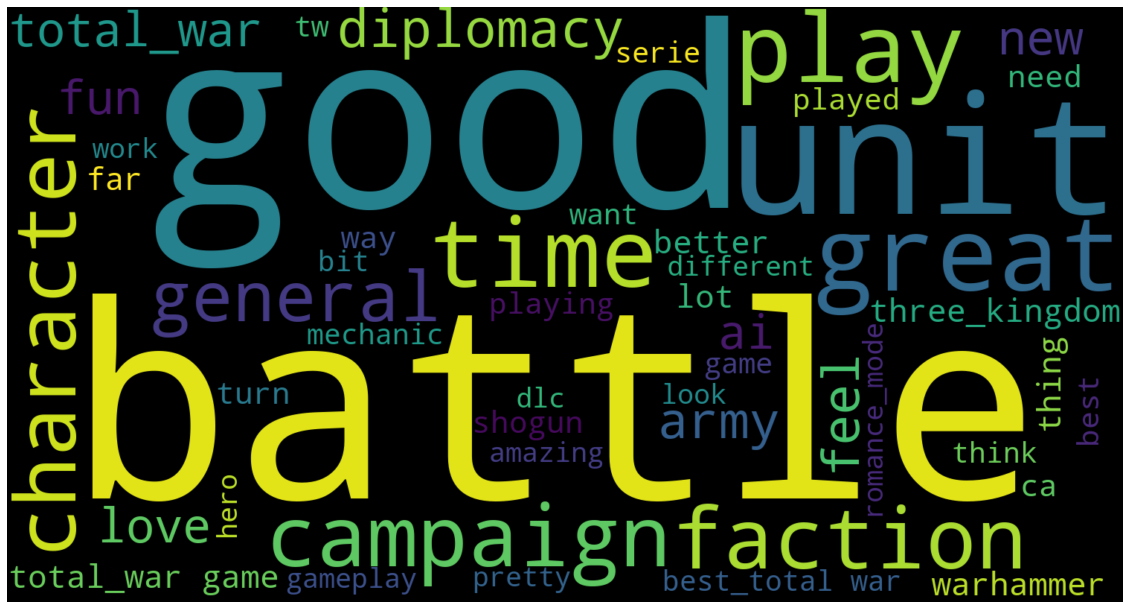

In [519]:
#generate wordcloud for 2grams
text_2grams = ' '.join(w for w in word_lst_2gram)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text_2grams)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

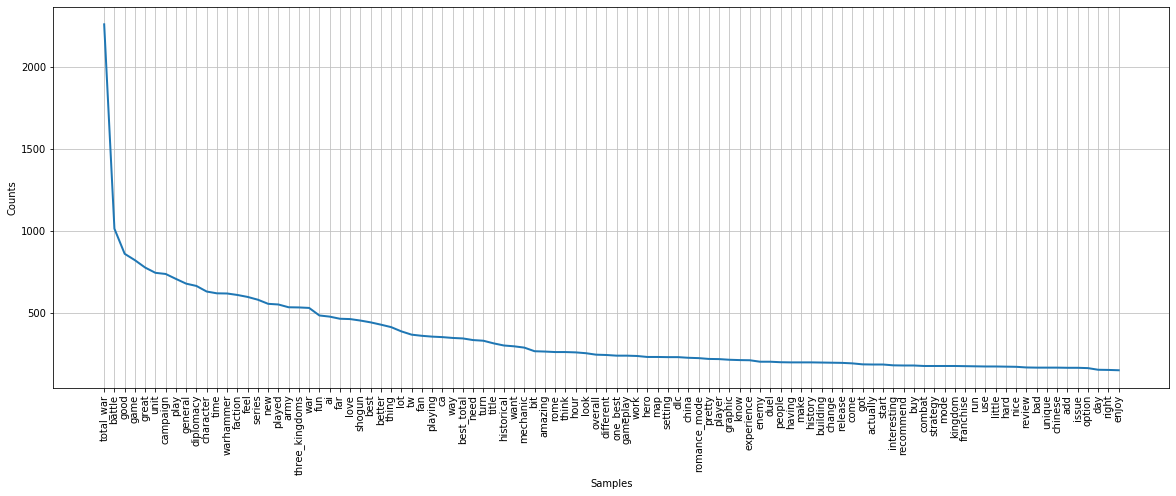

In [520]:
wordfreq_2gram = nltk.FreqDist(word_lst_2gram)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq_2gram.plot(100,cumulative=False)

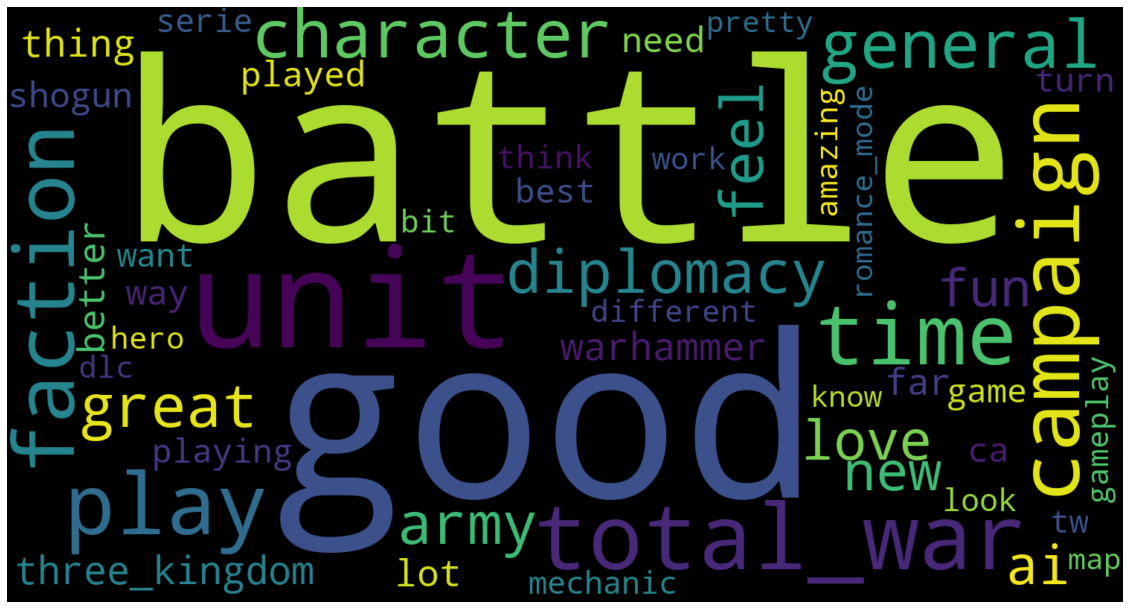

In [521]:
#generate wordcloud for 3grams
text_3grams = ' '.join(w for w in word_lst_3gram)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text_3grams)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

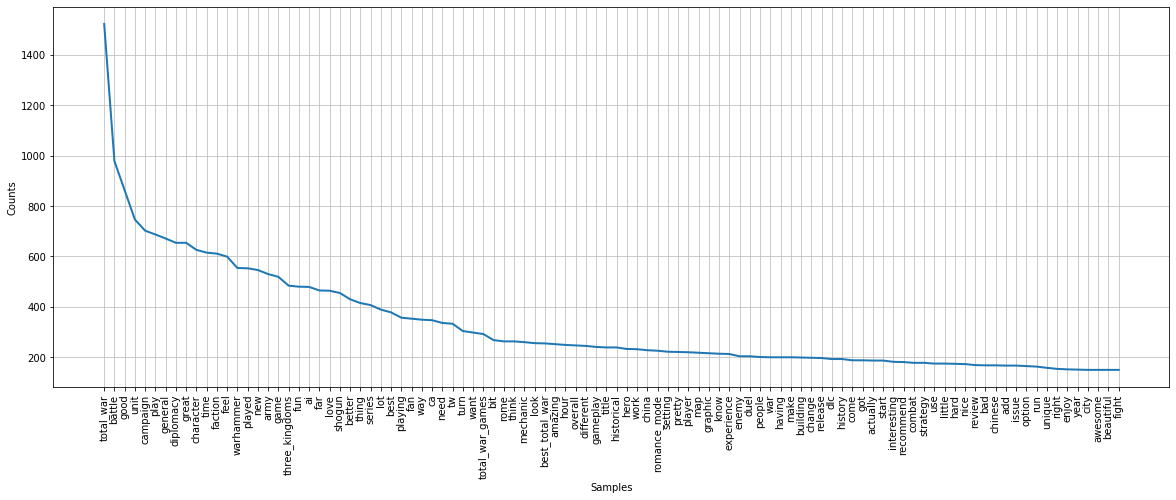

In [522]:
wordfreq_3gram = nltk.FreqDist(word_lst_3gram)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq_3gram.plot(100,cumulative=False)

### Preliminary analysis of n-grams models

Coherent n-grams such as 'best_total_war' have come up, and gameplay features such as 'romance_mode' (the less historically-authentic version based on the novel Romance of the Three Kingdoms) have appeared as n-gram terms.

**Next steps:**
- Try LDA first, see if topics are coherent. 
    - If not then try cleaning out some other words like 'best', since the ones that I want to be combined into n-grams have already been combined as such. 
    - Such words could generate noise/diminish coherence, but there is only one way to find out.
- Use dataset that includes 3grams for LDA because the most frequently occurring terms seem to be the most coherent, at first glance.

# References

Language detection package from Google: https://pypi.org/project/langdetect/